In [2]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
import scanpy as sc,anndata as ad
import squidpy as sq
import os
import sys
from scipy.sparse import vstack
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler,scale
from scipy.spatial import distance_matrix, distance
from sklearn.neighbors import KernelDensity
from scipy.spatial import KDTree
import networkx as nx
from sklearn.neighbors import NearestNeighbors
from tqdm import tqdm
from sklearn.neighbors import BallTree
import time
import rdata
from scipy.sparse import csr_matrix,bsr_matrix,coo_matrix,issparse
from scipy.sparse.linalg import inv
import scipy as sp
from  scipy.ndimage import gaussian_filter
import igraph as ig
import glasbey
import warnings
import cairocffi as cairo
from sklearn.metrics import adjusted_rand_score,make_scorer
from sklearn.model_selection import GridSearchCV, ParameterGrid
import libpysal
from esda.losh import LOSH
from multiprocessing import Pool
from mclustpy import mclustpy
from sklearn.cluster import KMeans
import torch
from GraphST import GraphST
import SEDR
from GraphST.utils import clustering
from scipy.stats import uniform, randint
from sklearn.model_selection import RandomizedSearchCV


NameError: name '_C' is not defined

In [2]:
def randomized_pca(data, n_components=20):
    # check if sparse 
        if issparse(data):
            data = data.toarray()
        pca = PCA(n_components=n_components, svd_solver='randomized', random_state=42)
        transformed_data = pca.fit_transform(data)
        return transformed_data, pca.explained_variance_ratio_



def fx_1NN(index, location_in):
    """
    Python equivalent of the fx_1NN function that is called in the loop.
    Computes the distance from the point at 'index' to its nearest neighbor.
    """
    distances = distance.cdist([location_in[index]], location_in, 'euclidean')
    nearest_neighbor = np.partition(distances, 1)[0, 1]  # 1st closest distance
    return nearest_neighbor

def fx_CHAOS(clusterlabel, location):
    matched_location = np.array(location)
    clusterlabel = np.array(clusterlabel)
    
    # Remove NA (None) values
    NAs = np.where(pd.isna(clusterlabel))[0]
    if len(NAs) > 0:
        clusterlabel = np.delete(clusterlabel, NAs)
        matched_location = np.delete(matched_location, NAs, axis=0)

    # Standardize the location data
    matched_location = scale(matched_location)

    unique_labels = np.unique(clusterlabel)
    dist_val = np.zeros(len(unique_labels))
    
    for count, k in enumerate(unique_labels):
        location_cluster = matched_location[clusterlabel == k]
        if location_cluster.shape[0] == 1:  # Only one point in cluster
            continue

        with Pool(5) as pool:  # Parallel processing with 5 cores
            results = pool.starmap(fx_1NN, [(i, location_cluster) for i in range(location_cluster.shape[0])])
        
        dist_val[count] = sum(results)
    
    dist_val = dist_val[~np.isnan(dist_val)]  # Remove any NaN values
    return np.sum(dist_val) / len(clusterlabel)

def calculate_local_density(coords, neighborhood_size):
    """
    Calculate the local density of each coordinate in a given neighborhood size.

    Parameters:
    - coords: ndarray of shape (n_samples, n_features) - spatial coordinates of cells.
    - neighborhood_size: float - the radius within which to calculate the local density.

    Returns:
    - local_density: ndarray of shape (n_samples,) - local density for each coordinate.
    """
    tree = KDTree(coords)
    
    # Query the tree to find the number of points within the neighborhood size (radius)
    densities = []
    for point in tqdm(coords):
        indices = tree.query_ball_point(point, r=neighborhood_size)
        # The density is the number of points within the neighborhood divided by the volume of the neighborhood
        density = len(indices) / (np.pi * neighborhood_size ** 2)  # Assuming 2D coordinates, adjust formula for 3D
        densities.append(density)
    
    return np.array(densities)

def plot_density(coords, local_density,n_size):
    """
    Plot coordinates and color by local density.

    Parameters:
    - coords: ndarray of shape (n_samples, n_features) - spatial coordinates of cells.
    - local_density: ndarray of shape (n_samples,) - local density for each coordinate.
    """
    plt.figure(figsize=(12, 10))
    ax = plt.gca()  # Get current axes
    
    # Scatter plot
    sc = ax.scatter(coords[:, 0], coords[:, 1]*-1, c=local_density, cmap='viridis', s=5)
    plt.colorbar(sc, label='Local Density')
    
    # Set equal aspect ratio
    ax.set_aspect('equal', adjustable='box')
    
    ax.set_xlabel('X Coordinate')
    ax.set_ylabel('Y Coordinate')
    plt.title(f'Spatial Coordinates Colored by Local Density: {n_size} microns')
    plt.show()


def build_sparse_distance_matrix(coords, distance_threshold=250,verbose = False):
    # Build KDTree and compute sparse distance matrix
    start_time = time.time()
    tree = KDTree(coords)
    end_time = time.time()
    tree_build_time = end_time - start_time
    
    start_time = time.time()
    sparse_dist_matrix = tree.sparse_distance_matrix(tree, max_distance=distance_threshold, output_type='coo_matrix')
    sparse_dist_matrix = sparse_dist_matrix.tocsr()  # Convert to CSR format
    end_time = time.time()
    matrix_compute_time = end_time - start_time

    if verbose:
        print(f"Time to build KDTree: {tree_build_time} seconds")
        print(f"Time to compute sparse distance matrix: {matrix_compute_time} seconds")
    
    return sparse_dist_matrix



def create_graph_and_cluster(adata, pca_counts, n_neighbors=250, n_clusters=7, cluster_algorithm='walktrap', verbose = False):
    # Create AnnData for PCA results
    pca_adata = sc.AnnData(X=pca_counts)
    
    # Measure time for the neighbors graph construction
    start_time = time.time()
    sc.pp.neighbors(pca_adata, use_rep='X', n_neighbors=n_neighbors, method='umap', metric='euclidean')
    end_time = time.time()
    graph_construction_time = end_time - start_time
    
    # Convert the neighbors graph to an igraph Graph object
    neighbors_graph = pca_adata.obsp['connectivities']
    sources, targets = neighbors_graph.nonzero()
    weights = neighbors_graph[sources, targets].A1
    g = ig.Graph(directed=False)
    g.add_vertices(pca_adata.n_obs)
    g.add_edges(zip(sources, targets))
    g.es['weight'] = weights
    
    # Perform Walktrap community detection
    if cluster_algorithm == 'walktrap':
        start_time = time.time()
        walktrap = g.community_walktrap(weights='weight')
        clusters = walktrap.as_clustering(n=n_clusters)
        end_time = time.time()
        cluster_time = end_time - start_time



    if verbose:
        print(f"Time to construct SNN graph: {graph_construction_time:.2f} seconds")
        print(f"Time for Walktrap community detection: {cluster_time:.2f} seconds")
    
    # Assign cluster labels to adata
    adata.obs[f'{cluster_algorithm}_clusters'] = pd.Categorical(clusters.membership)
    
    return adata


# def plot_results(adata, plot_pca=False, plot_clusters=True, distance_threshold=250, n_neighbors=250,cluster_algorithm = cluster_algorithm):
#     if plot_pca:
#         title = f"Smoothing Distance: {distance_threshold}, neighborhood size for clustering: {n_neighbors}"
#         sq.pl.spatial_scatter(
#             sq.pl.extract(adata, "X_spatial_smooth_pca"),
#             shape=None,
#             color=[f'rpca_{i + 1}' for i in range(10)],  # Adjust as per your needs
#             size=75,
#             figsize=(8, 8),
#             title=None,
#             ncols=2
#         )
#         plt.suptitle(title, fontsize=16, y=0.95)
#         plt.show()

#     if plot_clusters:
#         title = f"Smoothing Distance: {distance_threshold}, neighborhood size for clustering: {n_neighbors}"
#         sq.pl.spatial_scatter(adata, color=["ground_truth", "spatialPCA_with_labels",f'{cluster_algorithm}'], shape=None, figsize=(8, 8), size=150)
#         plt.suptitle(title, fontsize=16, y=0.95)
#         plt.show()

def compute_spatial_lag_genes(adata, knn_neighbors,data_matrix = None):
    coords = adata.obsm['spatial']
    tree = KDTree(coords)
    w = libpysal.weights.KNN(tree, k=knn_neighbors)
    weights_matrix = w.sparse
    if data_matrix is None:
        data_matrix = adata.X 
    spatial_lag_values = weights_matrix @ data_matrix
    return spatial_lag_values

def smooth_pca_values(adata, rpca_counts, sparse_dist_matrix, smoothing_style, sigma_x, sigma_y):
    if smoothing_style == "Inverse_sq_distance":
        inverse_sq_data = 1 / (sparse_dist_matrix.data ** 2 + 1000000000)
        inverse_sq_matrix = csr_matrix((inverse_sq_data, sparse_dist_matrix.indices, sparse_dist_matrix.indptr),
                                       shape=sparse_dist_matrix.shape)
        rpca_counts_sparse = csr_matrix(rpca_counts)
        smoothed_pca = inverse_sq_matrix.dot(rpca_counts_sparse)
        return smoothed_pca.toarray()

    if smoothing_style == "gaussian":
        sigma = [sigma_y, sigma_x]
        gaussian_smoothed_dist = gaussian_filter(sparse_dist_matrix.toarray(), sigma, mode='constant')
        smoothed_pca = gaussian_smoothed_dist @ rpca_counts
        return smoothed_pca

                        

                        

def compute_rpca_with_smoothing_and_clusters(adata, 
                                             distance_threshold=250, 
                                             n_neighbors=250, 
                                             smoothing_style = "Inverse_sq_distance",
                                             sigma_x = None,
                                             sigma_y = None,
                                             plot_pca=False,
                                             plot_clusters=True,
                                             n_clusters=7,
                                             variable_genes=False,
                                             library_size = False,
                                             knn_neighbors=10, 
                                             spatial_lag=False, 
                                             cluster_algorithm='walktrap',
                                             Hi = False,
                                             verbose = False):

    
    
        
    if spatial_lag == 'genes':
        spatial_lag_values = compute_spatial_lag_genes(adata, knn_neighbors)
        rpca_counts, explained_variance_ratio = randomized_pca(spatial_lag_values)
    elif spatial_lag == 'pca':
        residuals = adata.X if not variable_genes else adata[:, adata.uns['sepal_score'].index[:variable_genes].values].X
        rpca_counts, explained_variance_ratio = randomized_pca(residuals)
        spatial_lag_values = compute_spatial_lag_genes(adata, knn_neighbors, data_matrix=rpca_counts)
        rpca_counts, explained_variance_ratio = randomized_pca(spatial_lag_values)
        
    else:
        residuals = adata.X if not variable_genes else adata[:, adata.uns['sepal_score'].index[:variable_genes].values].X
        rpca_counts, explained_variance_ratio = randomized_pca(residuals)
        
        coords = adata.obsm['spatial']
        sparse_dist_matrix = build_sparse_distance_matrix(coords, distance_threshold=distance_threshold, verbose=verbose)

        if library_size:
            lib = adata.obs['nFeature_RNA'].values
            pca1_std = np.std(rpca_counts[:, 0], ddof=1) #st of first PC
            lib_std = np.std(lib, ddof=1) 
            # Standardize lib to have the same variance as PCA1
            lib_scaled = (pca1_std / lib_std) * lib
            
            #need to adjust to make the values on smae scale! 
            #lib = sd(PCA1)*lib/sd(lib.size)
            rpca_counts = np.hstack([rpca_counts,lib_scaled[:, np.newaxis]])
            
        rpca_counts = smooth_pca_values(adata, rpca_counts, sparse_dist_matrix, smoothing_style, sigma_x, sigma_y)
        print("ran inverse smoothing")
        print(distance_threshold)
        
        
        
        # Uncomment if using other methods 
        #rpca_counts, explained_variance_ratio = randomized_pca(smoothed_pca)
        
        

        #include local heteroskedasticity of first pca in second round of the pca 
        if Hi == 'pca':
            hi_dict = {}
            ylab_dict = {}
            tree = KDTree(coords)
            w = libpysal.weights.KNN(tree,k = knn_neighbors)
            for i,col in enumerate(rpca_counts.T):
                ls = LOSH(connectivity=w, inference="chi-square").fit(col)
                hi_dict[i] = ls.Hi
                ylab_dict[i] = ls.ylag
                
            

            hi_df = pd.DataFrame(hi_dict)
            ylab_df = pd.DataFrame(ylab_dict)

            smoothed_pca=np.hstack([rpca_counts,hi_df.values])


        #calculate rpca for the case without using spatial lag. 
            rpca_counts, explained_variance_ratio = randomized_pca(smoothed_pca)
    
    n_final_components = rpca_counts.shape[1]
    pca_df = pd.DataFrame(rpca_counts, index=adata.obs.index, columns=[f'rpca_{i + 1}' for i in range(n_final_components)])
    adata.obsm['X_spatial_smooth_pca'] = pca_df

    adata = create_graph_and_cluster(adata, pca_df.values, 
                                     n_neighbors=n_neighbors, 
                                     n_clusters=n_clusters, 
                                     cluster_algorithm=cluster_algorithm,
                                     verbose=verbose)

    num_clusters = len(set(adata.obs[f'{cluster_algorithm}_clusters']))
    palette = glasbey.create_palette(palette_size=num_clusters)
    adata.uns[f'{cluster_algorithm}_clusters_colors'] = palette

    ground_truth_labels = adata.obs['Cell_Types'].astype(str)
    #print(adata.obs)
    labels = adata.obs[f'{cluster_algorithm}_clusters'].astype(str)
    #ari = adjusted_rand_score(ground_truth_labels, walktrap_labels)
    CHAOS = fx_CHAOS(walktrap_labels, coords)
    #print(f'Adjusted Rand Index: {ari}')
    print(f'Spatial CHAOS score: {CHAOS}')

    plot_results(adata, plot_pca=plot_pca, plot_clusters=plot_clusters, distance_threshold=distance_threshold, n_neighbors=n_neighbors,cluster_algorithm=cluster_algorithm)

    return CHAOS


    
def plot_results(adata, plot_pca=False, plot_clusters=True, distance_threshold=250, n_neighbors=250,cluster_algorithm = 'walktrap'):
    if plot_pca:
        title = f"Smoothing Distance: {distance_threshold}, neighborhood size for clustering: {n_neighbors}"
        sq.pl.spatial_scatter(
            sq.pl.extract(adata, "X_spatial_smooth_pca"),
            shape=None,
            color=[f'rpca_{i + 1}' for i in range(10)],  # Adjust as per your needs
            size=20,
            figsize=(8, 8),
            title=None,
            ncols=2
        )
        plt.suptitle(title, fontsize=16, y=0.95)
        plt.show()
    
    if plot_clusters:
        title = f"Smoothing Distance: {distance_threshold}, neighborhood size for clustering: {n_neighbors}"
        sq.pl.spatial_scatter(adata, color=[f'{cluster_algorithm}_clusters'], shape=None, figsize=(8, 8), size=10)
        plt.suptitle(title, fontsize=16, y=0.95)
        plt.show() 

#how the pca and clustering will work

def clustering(adata, n_clusters=7, n_neighbors = 15,key='X_pca_smoothed', method='mclust'):
    """\
    Spatial clustering.

    Parameters
    ----------
    adata : anndata
        AnnData object of scanpy package.
    n_clusters : int, optional
        The number of clusters. The default is 7.
    radius : int, optional
        The number of neighbors considered during refinement. The default is 50.
    key : string, optional
        The key of the learned representation in adata.obsm. The default is 'emb'.
    method : string, optional
        The tool for clustering. Supported tools include 'mclust', 'leiden', and 'louvain'. The default is 'mclust'. 
    start : float
        The start value for searching. The default is 0.1.
    end : float 
        The end value for searching. The default is 3.0.
    increment : float
        The step size to increase. The default is 0.01.   
    refinement : bool, optional
        Refine the predicted labels or not. The default is False.

    Returns
    -------
    None.

    """
    
    # pca = PCA(n_components=20, random_state=42) 
    # embedding = pca.fit_transform(adata.obsm['emb'].copy())
    # adata.obsm['emb_pca'] = embedding
    
    if method == 'mclust':
        random_seed = 2020
        np.random.seed(random_seed)
        import rpy2.robjects as robjects
        robjects.r.library("mclust")
        
        import rpy2.robjects.numpy2ri
        rpy2.robjects.numpy2ri.activate()
        r_random_seed = robjects.r['set.seed']
        r_random_seed(random_seed)
        rmclust = robjects.r['Mclust']
        res = rmclust(rpy2.robjects.numpy2ri.numpy2rpy(adata.obsm[key]), n_clusters, 'EEE')
        mclust_res = np.array(res[-2])
        # res = mclustpy(adata.obsm['X_pca_smoothed'],G = n_clusters,modelNames = 'EEE',random_seed = 2020)
        adata.obs[f'{method}_clusters'] = mclust_res
        adata.obs[f'{method}_clusters'] = adata.obs[f'{method}_clusters'].astype('int')
        adata.obs[f'{method}_clusters'] = adata.obs[f'{method}_clusters'].astype('category')
       
    
    
    elif method == 'leiden':
        SEDR.leiden(adata,n_clusters,n_neighbors = n_neighbors, use_rep = "X_pca_smoothed",key_added = 'leiden_clusters')
       #res = search_res(adata, n_clusters, use_rep='X_pca_smoothed', method=method, start=start, end=end, increment=increment)
       #sc.tl.leiden(adata, random_state=0, resolution=res,key_added = 'leiden_clusters')
       
        
    elif method == 'louvain':
        SEDR.louvain(adata,n_clusters,n_neighbors = n_neighbors,use_rep = "X_pca_smoothed",key_added = 'louvain_clusters')
        
       #res = search_res(adata, n_clusters, use_rep='X_pca_smoothed', method=method, start=start, end=end, increment=increment)
       #sc.tl.louvain(adata, random_state=0, resolution=res,key_added = 'louvain_clusters')
       
        
    elif method =="walktrap":
        neighbors_graph = adata.obsp['connectivities']
        sources, targets = neighbors_graph.nonzero()
        weights = neighbors_graph[sources, targets].A1
        g = ig.Graph(directed=False)
        g.add_vertices(adata.n_obs)
        g.add_edges(zip(sources, targets))
        g.es['weight'] = weights
    
        # Perform Walktrap community detection
        start_time = time.time()
        walktrap = g.community_walktrap(weights='weight')
        clusters = walktrap.as_clustering(n=n_clusters)
        end_time = time.time()
        cluster_time = end_time - start_time
        adata.obs[f'{method}_clusters'] = pd.Categorical(clusters.membership)

    elif method == "KMeans":
        kmeans = KMeans(n_clusters = n_clusters,random_state = 10)
        adata.obs[f'{method}_clusters'] = pd.Categorical(kmeans.fit_predict(adata.obsm['X_pca_smoothed']))

    return adata


#search resolution for cluster numbers 
def search_res(adata, n_clusters, method='leiden', use_rep='X_pca_smoothed', start=0.1, end=3.0, increment=0.01):
    '''\
    Searching corresponding resolution according to given cluster number
    
    Parameters
    ----------
    adata : anndata
        AnnData object of spatial data.
    n_clusters : int
        Targetting number of clusters.
    method : string
        Tool for clustering. Supported tools include 'leiden' and 'louvain'. The default is 'leiden'.    
    use_rep : string
        The indicated representation for clustering.
    start : float
        The start value for searching.
    end : float 
        The end value for searching.
    increment : float
        The step size to increase.
        
    Returns
    -------
    res : float
        Resolution.
        
    '''
    print('Searching resolution...')
    label = 0
    #sc.pp.neighbors(adata, n_neighbors=50, use_rep=use_rep)
    print(start,end,increment)
    for res in sorted(list(np.arange(start, end, increment)), reverse=True):
        if method == 'leiden':
           sc.tl.leiden(adata, random_state=0, resolution=res,key_added = 'leiden_smoothed')
           count_unique = len(pd.DataFrame(adata.obs['leiden_smoothed']).leiden_smoothed.unique())
           print('resolution={}, cluster number={}'.format(res, count_unique))
        elif method == 'louvain':
           sc.tl.louvain(adata, random_state=0, resolution=res,key_added = 'louvain_smoothed')
           count_unique = len(pd.DataFrame(adata.obs['louvain_smoothed']).louvain_smoothed.unique()) 
           print('resolution={}, cluster number={}'.format(res, count_unique))
        if count_unique == n_clusters:
            label = 1
            break

    assert label==1, "Resolution is not found. Please try bigger range or smaller step!." 
       
    return res  


def add_feature(adata, pca_values, feature = 'library_size',density_distance = 0, verbose = False):

    

    if feature == 'library_size':
        
        lib = adata.obs['n_genes_by_counts'].values
        pca1_std = np.std(pca_values[:, 0], ddof=1) #st of first PC
        lib_std = np.std(lib, ddof=1) 
        
        # Standardize lib to have the same variance as PCA1
        lib_scaled = (pca1_std / lib_std) * lib
            

        if verbose:
            print("Added Library size as a feature")
        #stack together 
        pca_counts = np.hstack([pca_values,lib_scaled[:, np.newaxis]])
        return pca_counts
        
    if feature == 'density':
        
        
        if verbose:
            print(f"Added local density of {density_distance} as a feature")
        coords = adata.obsm['spatial']
        density = calculate_local_density(coords, density_distance)

        #standardize density to be on same scale as pca values 
        pca1_std = np.std(pca_values[:, 0], ddof=1) #st of first PC
        density_std = np.std(density,ddof = 1)
        density_scaled = (pca1_std/density_std)*density

        #stack together 
        pca_counts = np.hstack([pca_values,density_scaled.reshape((-1,1))])
        #print(type(pca_counts))
        return pca_counts

def run_experiment(adata, 
                   distance_threshold=250, 
                   n_neighbors=250, 
                   plot_pca=False,
                   plot_clusters=True,
                   n_clusters=7,
                   library_size = False,
                   density = False,
                   density_distance = 30,
                   cluster_algorithm='walktrap',
                   verbose = False,
                   ground_truth_labs = 'region'):
    

   
    start_time = time.time()
    rpca_counts, explained_variance_ratio = randomized_pca(adata.X)
    #print(type(rpca_counts))

    if library_size:
        #add the library size feature in before smoothing with distance matrix 
        rpca_counts=add_feature(adata,rpca_counts,feature = 'library_size')
        #print(type(rpca_counts))
    
    #now for the spatial smoothing logic: 
    coords = adata.obsm['spatial']
    sparse_dist_matrix = build_sparse_distance_matrix(coords, distance_threshold=distance_threshold, verbose=verbose)
    
    #calculate inverse squared distance 
    inverse_sq_data = 1 / (sparse_dist_matrix.data ** 2 + 1000000000)
    inverse_sq_matrix = csr_matrix((inverse_sq_data, sparse_dist_matrix.indices, sparse_dist_matrix.indptr),
                                   shape=sparse_dist_matrix.shape)
    
    
    
    #new code: scaling the sparse dist matrix prior to smoothing to keep things on the same scale
    # Compute the row sums for normalization
    row_sums = inverse_sq_matrix.sum(axis=1).A1  # Convert to a 1D array
    row_sums[row_sums == 0] = 1  # Avoid division by zero for rows that sum to zero
    
    # Normalize the inverse squared matrix by the row sums
    inverse_sq_matrix_normalized = inverse_sq_matrix.multiply(1 / row_sums[:, np.newaxis])
    
    # Multiply the rPCA counts by the normalized inverse squared matrix
    rpca_counts_sparse = csr_matrix(rpca_counts)
    smoothed_pca = inverse_sq_matrix_normalized @ rpca_counts_sparse
    
    # Convert to dense array if needed
    smoothed_pca = smoothed_pca.toarray()
    
    
    

    
    
    if density:
        #update x_pca_smoothed with the density feature
        smoothed_pca = add_feature(adata,smoothed_pca,feature = 'density',density_distance = density_distance)

    #do a quick check on the X_pca_smoothed and see if the dims are greater than 20. If so, reduce again. 
    if library_size or density:

        #if eithe library_size or density are true, run second rouund of rPCA 
        smoothed_pca,_= randomized_pca(smoothed_pca, n_components=20)

    #add the final_pca to the adata object in a new .obs called X_pca_smoothed
    adata.obsm['X_pca_smoothed'] = smoothed_pca
    end_time = time.time()
    dim_run_time = end_time-start_time
    #print(f'Dim reduction took: {dim_run_time:.2f} seconds')   
        
        
    #now we have to run the clustering parts of the code. Update the clustering part of the code 

    #first build the nearest neighbors graph 
    start_time = time.time()
    sc.pp.neighbors(adata, n_neighbors=n_neighbors, use_rep='X_pca_smoothed',)
    end_time = time.time()
    graph_run_time = end_time-start_time
    #print(f'Graph construction took:{graph_run_time:.2f} seconds')
    
    start_time = time.time()
    adata = clustering(adata, n_clusters=n_clusters, n_neighbors = n_neighbors,key='X_pca_smoothed', method=cluster_algorithm)
    end_time = time.time()
    cluster_run_time = end_time-start_time
    #print(f'Clustering took:{cluster_run_time:.2f} seconds')

    num_clusters = len(set(adata.obs[f'{cluster_algorithm}_clusters']))
    palette = glasbey.create_palette(palette_size=num_clusters)
    adata.uns[f'{cluster_algorithm}_clusters_colors'] = palette

    ground_truth_labels = adata.obs[ground_truth_labs].astype(str)
    #print(adata.obs)
    labels = adata.obs[f'{cluster_algorithm}_clusters'].astype(str)
    ari = adjusted_rand_score(ground_truth_labels, labels)
    #CHAOS = fx_CHAOS(labels, coords)
    #print(f'Adjusted Rand Index: {ari}')
    print(f'ARI: {ari}')

    if plot_clusters:
        plot_results(adata, plot_pca=False, plot_clusters=True, distance_threshold=distance_threshold, n_neighbors=n_neighbors,cluster_algorithm = cluster_algorithm)
    return ari,dim_run_time, graph_run_time, cluster_run_time











    



In [26]:
# directory = "/dartfs-hpc/rc/lab/F/FrostH/members/igingerich/public_data/xenium_cancer/processed_data"

# adata = sc.read_h5ad(os.path.join(directory,"xenium_cancer_unprocessed.h5ad"))

# #add spatial
# df = pd.read_csv(os.path.join(directory,"coordinates.csv"),index_col = 0)
# df['y'] = -1*df['y']

# #add as spatial coords 
# spatial = df[['x','y']].to_numpy()
# adata.obsm['spatial'] = spatial






# #processing: 
# #pre-process/quality control 
# #Mitochondrail genes: 

# adata.var["mt"] = adata.var_names.str.startswith("MT-")
# # ribosomal genes
# adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
# # hemoglobin genes
# adata.var["hb"] = adata.var_names.str.contains("^HB[^(P)]")


# sc.pp.calculate_qc_metrics(
#     adata, inplace=True, log1p=True
# )

# sc.pl.violin(
#     adata,
#     ["nCount_originalexp", "nFeature_originalexp"],
#     jitter=0.4,
#     multi_panel=True,
# )

# sc.pp.filter_cells(adata, min_genes=20)
# sc.pp.filter_genes(adata, min_cells=3)

# # Saving count data
# adata.layers["counts"] = adata.X.copy()
# # Normalizing to median total counts
# sc.pp.normalize_total(adata)
# # Logarithmize the data
# sc.pp.log1p(adata)

# #Variable genes 
# sc.pp.highly_variable_genes(adata, flavor="seurat", n_top_genes=3000)

#adata.write_h5ad("/dartfs-hpc/rc/lab/F/FrostH/members/igingerich/public_data/xenium_cancer/processed_data/xenium_cancer_processed.h5ad")

In [3]:
directory = "/dartfs-hpc/rc/lab/F/FrostH/members/igingerich/public_data/xenium_cancer/processed_data"

adata = sc.read_h5ad(os.path.join(directory,"xenium_cancer_processed.h5ad"))
adata

AnnData object with n_obs × n_vars = 565916 × 541
    obs: 'orig.ident', 'nCount_originalexp', 'nFeature_originalexp', 'sample_id', 'cell_id', 'transcript_id', 'overlaps_nucleus', 'z_location', 'qv', 'region', 'technology', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'n_genes'
    var: 'gene', 'genetype', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'log1p'
    obsm: 'spatial'
    layers: 'counts'

/dartfs-hpc/rc/lab/F/FrostH/members/igingerich/envs/miniconda3/envs/r-kernel/lib/python3.12/site-packages/squidpy/pl/_spatial_utils.py:955: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


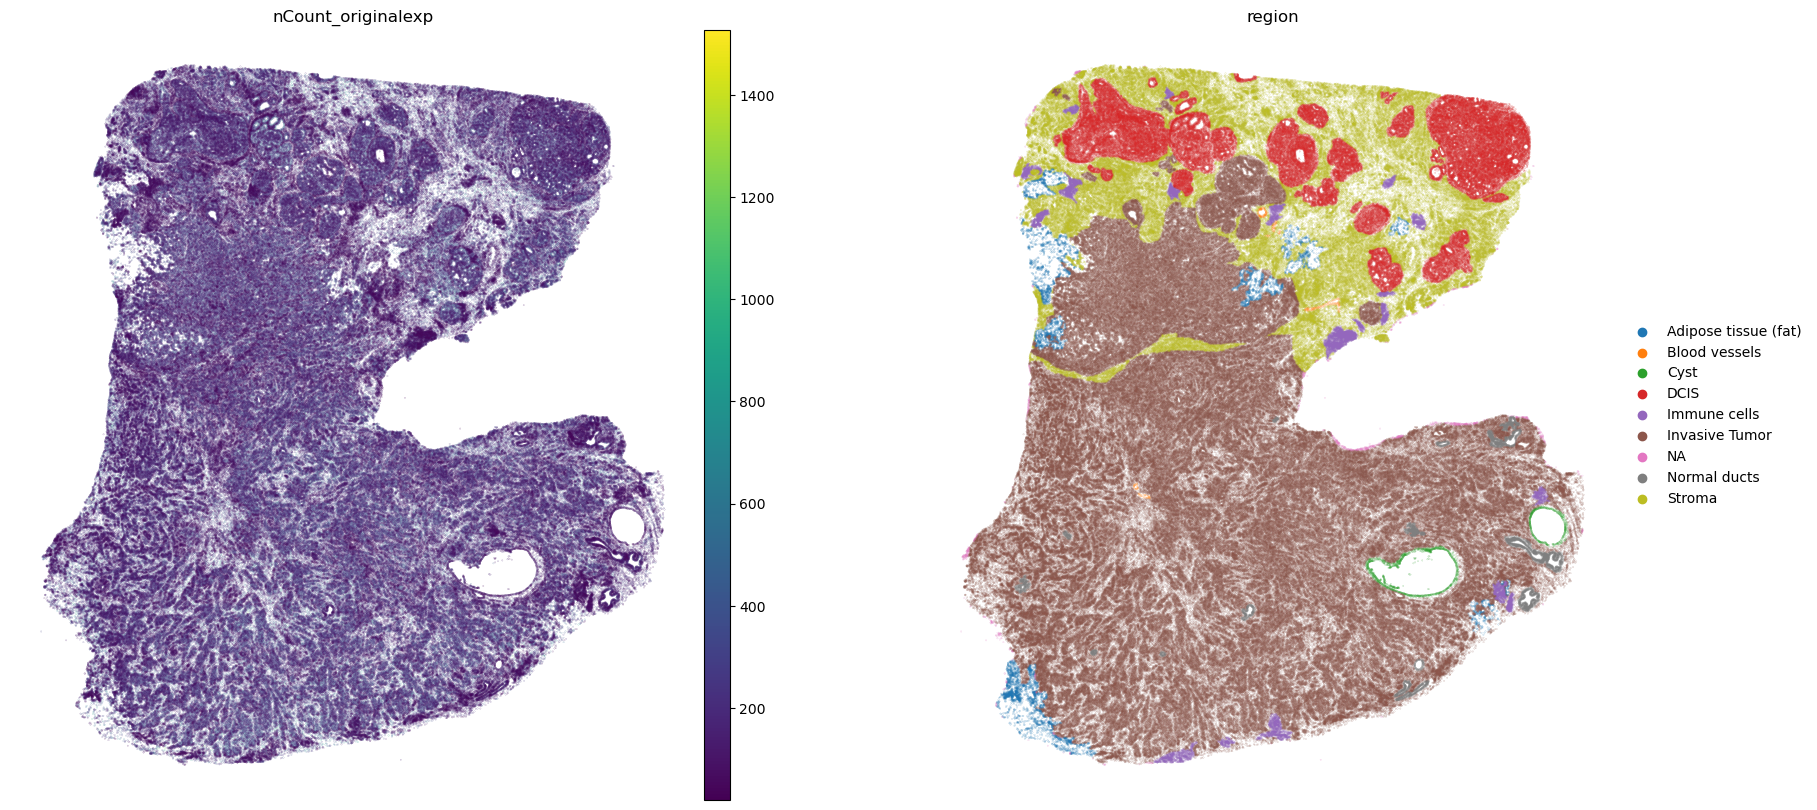

In [30]:
sq.pl.spatial_scatter(
    adata,
    color=["nCount_originalexp","region"],
    frameon=False,
    shape=None,
    size = 0.01,
    figsize = (10,10),
    ncols = 2
    
)

Time to build KDTree: 0.1549546718597412 seconds
Time to compute sparse distance matrix: 0.30323195457458496 seconds
Dim reduction took: 13.09 seconds


2024-09-18 12:32:59.722680: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-18 12:32:59.733786: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-18 12:32:59.736978: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-18 12:32:59.746241: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-18 12:33:05.384113: W tensorflow/compiler/tf2

Graph construction took:97.47 seconds
fitting ...
  |======================================================================| 100%
Clustering took:461.11 seconds
ARI: 0.23839573444635276


/dartfs-hpc/rc/lab/F/FrostH/members/igingerich/envs/miniconda3/envs/r-kernel/lib/python3.12/site-packages/squidpy/pl/_spatial_utils.py:955: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


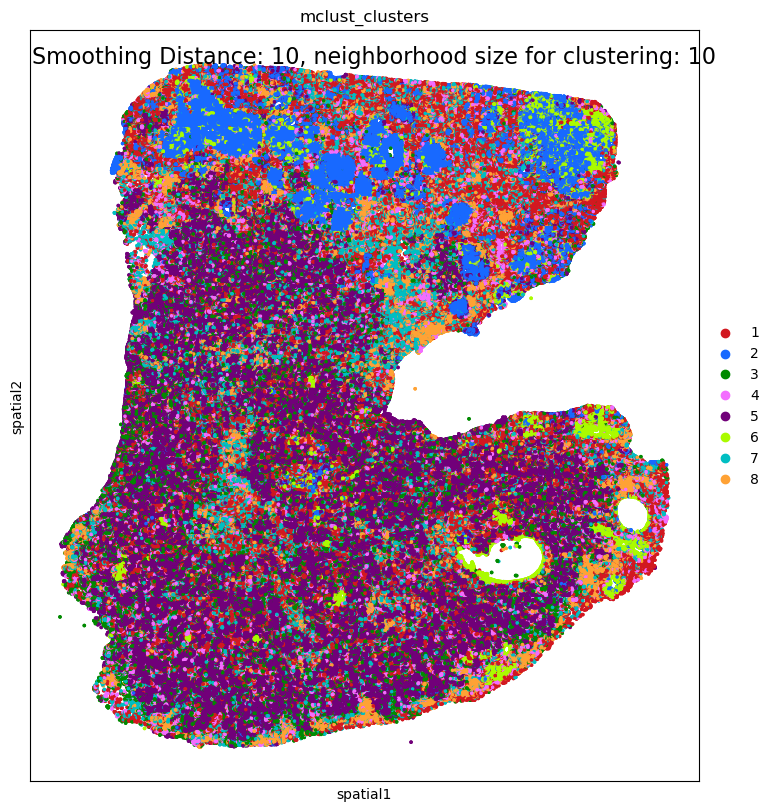

(0.23839573444635276,
 13.091488122940063,
 97.47259330749512,
 461.11211919784546)

In [31]:
run_experiment(adata, 
                   distance_threshold=10, 
                   n_neighbors=10, 
                   plot_pca=False,
                   plot_clusters=True,
                   n_clusters=8,
                   library_size = False,
                   density = False,
                   density_distance = 10,
                   cluster_algorithm='mclust',
                   verbose = True,
                   ground_truth_labs = 'region')

In [ ]:
def parameter_sweep(adata, n_neighbors, n_clusters, 
                    library_size, density, density_distance, 
                    algorithms, verbose, n_iterations):
    
    # Precompute a vector of random distance_threshold values
    distance_thresholds = np.random.uniform(5,100, n_iterations)
    
    results = []  # List to store results
    
    for algorithm in algorithms:
        for i in range(n_iterations):
            distance_threshold = distance_thresholds[i]  # Use the precomputed value
            print(f"Iteration {i + 1} - Using distance_threshold: {distance_threshold:.2f}")  # Debug output
            
            try:
                # Call the run_experiment function and unpack returns
                ari, dim_run_time, graph_run_time, cluster_run_time = run_experiment(
                    adata,
                    distance_threshold=distance_threshold,
                    n_neighbors=n_neighbors,
                    plot_pca=False,
                    plot_clusters=False,
                    n_clusters=n_clusters,
                    library_size=library_size,
                    density=density,
                    density_distance=density_distance,
                    cluster_algorithm=algorithm,
                    verbose=verbose,
                    ground_truth_labs = 'region'
                    
                )
                
                # Store the results in a dictionary
                result = {
                    'distance_threshold': distance_threshold,
                    'n_neighbors': n_neighbors,
                    'n_clusters': n_clusters,
                    'library_size': library_size,
                    'density': density,
                    'density_distance': density_distance,
                    'cluster_algorithm': algorithm,
                    'verbose': verbose,
                    'ARI': ari,
                    'dim_run_time': dim_run_time,
                    'graph_run_time': graph_run_time,
                    'cluster_run_time': cluster_run_time
                }
                results.append(result)
            
            except Exception as e:
                #print(f"Error with distance_threshold={distance_threshold:.2f} and algorithm={algorithm}: {e}")
                # Store NaN for ARI and times if there's an error
                results.append({'distance_threshold': distance_threshold, 'cluster_algorithm': algorithm, 
                                'ARI': float('nan'), 'dim_run_time': float('nan'), 
                                'graph_run_time': float('nan'), 'cluster_run_time': float('nan')})

    # Convert the results list into a DataFrame
    results_df = pd.DataFrame(results)
    return results_df


# Parameters to sweep
n_neighbors = 10
n_clusters = 8
library_size = False
density = False
density_distance = 10
verbose = False

n_iterations = 50  # Specify how many iterations you want to run

# List of clustering algorithms to test
algorithms = ['louvain']

# Run the parameter sweep
results_df = parameter_sweep(adata, n_neighbors, n_clusters, 
                              library_size, density, density_distance, 
                              algorithms, verbose, n_iterations)

# Output the results
print(results_df)

Iteration 1 - Using distance_threshold: 77.69
Dim reduction took: 14.28 seconds


2024-09-22 09:37:32.525418: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-22 09:37:32.535325: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-22 09:37:32.545445: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-22 09:37:32.548327: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-22 09:37:32.556741: I tensorflow/core/platform/cpu_feature_guar

Graph construction took:105.40 seconds
Clustering took:83.90 seconds
ARI: 0.05326661877979392
Iteration 2 - Using distance_threshold: 48.05
Dim reduction took: 8.57 seconds
Graph construction took:40.36 seconds
Clustering took:103.31 seconds
ARI: 0.21468094824044462
Iteration 3 - Using distance_threshold: 24.31
Dim reduction took: 5.79 seconds
Graph construction took:42.92 seconds
Clustering took:362.66 seconds
ARI: 0.30035915543870373
Iteration 4 - Using distance_threshold: 81.18
Dim reduction took: 14.64 seconds
Graph construction took:40.02 seconds
Clustering took:83.86 seconds
ARI: 0.04147937353459649
Iteration 5 - Using distance_threshold: 76.62
Dim reduction took: 13.70 seconds
Graph construction took:39.20 seconds
Clustering took:79.69 seconds
ARI: 0.06144846563339038
Iteration 6 - Using distance_threshold: 43.07
Dim reduction took: 7.56 seconds
Graph construction took:40.79 seconds
Clustering took:92.76 seconds
ARI: 0.24536744588766637
Iteration 7 - Using distance_threshold: 66

IOStream.flush timed out


Clustering took:94.51 seconds
ARI: 0.2044647228419638
Iteration 38 - Using distance_threshold: 38.96
Dim reduction took: 7.32 seconds
Graph construction took:42.72 seconds
Clustering took:109.18 seconds
ARI: 0.3054409997647091
Iteration 39 - Using distance_threshold: 61.83
Dim reduction took: 10.78 seconds
Graph construction took:39.89 seconds
Clustering took:87.00 seconds
ARI: 0.1271216488991329
Iteration 40 - Using distance_threshold: 24.17
Dim reduction took: 5.83 seconds
Graph construction took:42.88 seconds
Clustering took:440.56 seconds
ARI: 0.4587540456531865
Iteration 41 - Using distance_threshold: 52.25
Dim reduction took: 9.16 seconds
Graph construction took:40.75 seconds
Clustering took:99.23 seconds
ARI: 0.19779735407084253
Iteration 42 - Using distance_threshold: 70.22
Dim reduction took: 12.51 seconds
Graph construction took:41.23 seconds
Clustering took:85.42 seconds
ARI: 0.07783836172676653
Iteration 43 - Using distance_threshold: 42.16
Dim reduction took: 7.56 seconds


IOStream.flush timed out


In [1]:
%reset -f

In [ ]:
results_df.to_csv("/dartfs-hpc/rc/lab/F/FrostH/members/igingerich/public_data/xenium_cancer/processed_data/param_sweep_results/ARI_distance_threshold_louvain_big_jupyter.csv",
                  index = False)


In [4]:
def parameter_sweep(adata, n_neighbors, n_clusters, 
                    library_size, density, density_distance, 
                    algorithms, verbose, n_iterations):
    
    # Precompute a vector of random distance_threshold values
    distance_thresholds = np.random.uniform(5,100, n_iterations)
    
    results = []  # List to store results
    
    for algorithm in algorithms:
        for i in range(n_iterations):
            distance_threshold = distance_thresholds[i]  # Use the precomputed value
            print(f"Iteration {i + 1} - Using distance_threshold: {distance_threshold:.2f}")  # Debug output
            
            try:
                # Call the run_experiment function and unpack returns
                ari, dim_run_time, graph_run_time, cluster_run_time = run_experiment(
                    adata,
                    distance_threshold=distance_threshold,
                    n_neighbors=n_neighbors,
                    plot_pca=False,
                    plot_clusters=False,
                    n_clusters=n_clusters,
                    library_size=library_size,
                    density=density,
                    density_distance=density_distance,
                    cluster_algorithm=algorithm,
                    verbose=verbose,
                    ground_truth_labs = 'region'
                    
                )
                
                # Store the results in a dictionary
                result = {
                    'distance_threshold': distance_threshold,
                    'n_neighbors': n_neighbors,
                    'n_clusters': n_clusters,
                    'library_size': library_size,
                    'density': density,
                    'density_distance': density_distance,
                    'cluster_algorithm': algorithm,
                    'verbose': verbose,
                    'ARI': ari,
                    'dim_run_time': dim_run_time,
                    'graph_run_time': graph_run_time,
                    'cluster_run_time': cluster_run_time
                }
                results.append(result)
            
            except Exception as e:
                #print(f"Error with distance_threshold={distance_threshold:.2f} and algorithm={algorithm}: {e}")
                # Store NaN for ARI and times if there's an error
                results.append({'distance_threshold': distance_threshold, 'cluster_algorithm': algorithm, 
                                'ARI': float('nan'), 'dim_run_time': float('nan'), 
                                'graph_run_time': float('nan'), 'cluster_run_time': float('nan')})

    # Convert the results list into a DataFrame
    results_df = pd.DataFrame(results)
    return results_df


# Parameters to sweep
n_neighbors = 10
n_clusters = 8
library_size = False
density = False
density_distance = 10
verbose = False

n_iterations = 50  # Specify how many iterations you want to run

# List of clustering algorithms to test
algorithms = ['leiden']

# Run the parameter sweep
results_df = parameter_sweep(adata, n_neighbors, n_clusters, 
                              library_size, density, density_distance, 
                              algorithms, verbose, n_iterations)

# Output the results
print(results_df)
results_df.to_csv("/dartfs-hpc/rc/lab/F/FrostH/members/igingerich/public_data/xenium_cancer/processed_data/param_sweep_results/ARI_distance_threshold_leiden_jupyter.csv",
                  index = False)

Iteration 1 - Using distance_threshold: 64.22


2024-09-22 21:34:47.900413: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-22 21:34:48.158286: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-22 21:34:48.230534: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-22 21:34:48.808764: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-22 21:34:55.278598: W tensorflow/compiler/tf2

ARI: 0.054282329958227855
Iteration 2 - Using distance_threshold: 8.63
ARI: 0.16128665669925174
Iteration 3 - Using distance_threshold: 77.94
ARI: 0.033356214218440844
Iteration 4 - Using distance_threshold: 27.43
ARI: 0.22996648347185122
Iteration 5 - Using distance_threshold: 79.31
ARI: 0.03003215669440526
Iteration 6 - Using distance_threshold: 8.31
ARI: 0.18504127126844477
Iteration 7 - Using distance_threshold: 99.00
ARI: 0.02099895310704233
Iteration 8 - Using distance_threshold: 48.98
ARI: 0.12989363012385324
Iteration 9 - Using distance_threshold: 28.95
ARI: 0.30111518978069135
Iteration 10 - Using distance_threshold: 99.92
ARI: 0.022475372397836674
Iteration 11 - Using distance_threshold: 27.49
ARI: 0.3503443339069849
Iteration 12 - Using distance_threshold: 87.46
ARI: 0.02230243358534633
Iteration 13 - Using distance_threshold: 42.48
ARI: 0.17848276761140194
Iteration 14 - Using distance_threshold: 11.27



KeyboardInterrupt



In [ ]:
def parameter_sweep(adata, distance_threshold, n_clusters, 
                    library_size, density, density_distance, 
                    algorithms, verbose, n_iterations):
    
    # Precompute a vector of random distance_threshold values
    #distance_thresholds = np.random.uniform(5,100, n_iterations)
    n_neighbors_all = np.random.randint(5,50,n_iterations)
    results = []  # List to store results
    
    for algorithm in algorithms:
        for i in range(n_iterations):
            #distance_threshold = distance_thresholds[i]  # Use the precomputed value
            n_neighbors = n_neighbors_all[i]
            print(f"Iteration {i + 1} - Using n_neighbors: {n_neighbors:.2f}")  # Debug output
            
            try:
                # Call the run_experiment function and unpack returns
                ari, dim_run_time, graph_run_time, cluster_run_time = run_experiment(
                    adata,
                    distance_threshold=distance_threshold,
                    n_neighbors=n_neighbors,
                    plot_pca=False,
                    plot_clusters=False,
                    n_clusters=n_clusters,
                    library_size=library_size,
                    density=density,
                    density_distance=density_distance,
                    cluster_algorithm=algorithm,
                    verbose=verbose,
                    ground_truth_labs = 'region'
                    
                )
                
                # Store the results in a dictionary
                result = {
                    'distance_threshold': distance_threshold,
                    'n_neighbors': n_neighbors,
                    'n_clusters': n_clusters,
                    'library_size': library_size,
                    'density': density,
                    'density_distance': density_distance,
                    'cluster_algorithm': algorithm,
                    'verbose': verbose,
                    'ARI': ari,
                    'dim_run_time': dim_run_time,
                    'graph_run_time': graph_run_time,
                    'cluster_run_time': cluster_run_time
                }
                results.append(result)
            
            except Exception as e:
                #print(f"Error with n_neighbors={n_neighbors:.2f} and algorithm={algorithm}: {e}")
                # Store NaN for ARI and times if there's an error
                results.append({'n_neighbors': n_neighbors, 'cluster_algorithm': algorithm, 
                                'ARI': float('nan'), 'dim_run_time': float('nan'), 
                                'graph_run_time': float('nan'), 'cluster_run_time': float('nan')})

    # Convert the results list into a DataFrame
    results_df = pd.DataFrame(results)
    return results_df


# Parameters to sweep
distance_threshold = 26.46
#n_neighbors = 10
n_clusters = 8
library_size = False
density = False
density_distance = 10
verbose = False

n_iterations = 50  # Specify how many iterations you want to run

# List of clustering algorithms to test
algorithms = ['louvain']

# Run the parameter sweep
results_df = parameter_sweep(adata, distance_threshold, n_clusters, 
                              library_size, density, density_distance, 
                              algorithms, verbose, n_iterations)

# Output the results
print(results_df)
results_df.to_csv("/dartfs-hpc/rc/lab/F/FrostH/members/igingerich/public_data/xenium_cancer/processed_data/param_sweep_results/ARI_n_neighbors_jupyter.csv",
                  index = False)

Iteration 1 - Using n_neighbors: 34.00


2024-09-26 10:26:52.900940: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-26 10:26:53.701149: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-26 10:26:53.986041: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-26 10:26:54.066626: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-26 10:26:54.692561: I tensorflow/core/platform/cpu_feature_guar